# Deep Learning for Computer Vision:  Assignment 3


## Computer Science: COMS W 4995 006


### Due: March 6, 2018

#### Problem

You are given two dimensional input from three separate classes. Your task is to implement a multi-layer perceptron (MLP) 3-class classifier with multiple hidden layers and a regularization on the weights. For the activiation function of the hidden units use ReLU or leaky ReLU. For the predictions use softmax on a linear output layer as we did in class. Your loss layer should compute $-\log P(y = i \,|{\bf x})$ where $i$ is the correct label according to the training data.

a) Implement each layer type (hidden, output, and loss) as separate python classes, each with methods for initialization, forward propagation, and backpropagation.

b) Implement a MLP as its own class, with separate methods for initialization, adding a layer, forward propagation, backpropagation, training and prediction. 

c) Let the layer dimensions be parameters passed when the network is created.

d) Let the number of training epochs, the mini-batch size, and the regularization parameter be parameters that are passed when training the network.

e) Build and run your network using your own constructs. The code for doing this might look like:

In [ ]:
NN = MLP()
NN.add_layer('Hidden', dim_in=2, dim_out=16)
NN.add_layer('Hidden', dim_in=16, dim_out=16)
NN.add_layer('Hidden', dim_in=16, dim_out=16)
NN.add_layer('Output', dim_in=16, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.0)
plot_loss(loss)
plot_decision_regions(NN)

f) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the three different labels. 

g) Repeat varying the number of hidden units (3, 8, 16), the number of hidden layers (1 and 3), and the regularization value (0 and some other value of your choosing).

h) Now replace your ReLU activation function with a softplus function and repeat.

Grading: a-g=90%, h=10%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.  

#### YOUR CODE MUST BE YOUR OWN.
_______________________________________________________________



Let's start by importing some libraries.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Let's make up our 2D data for our three classes.

In [2]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = random.randint(0,1)
    x2 = random.randint(0,1)
    if x1 == 1 and x2 == 0:
        y = 0
    elif x1 == 0 and x2 == 1:
        y = 0
    elif x1 == 0 and x2 == 0:
        y = 1
    else:
        y = 2
    x1 = 1.0 * x1 + 0.20 * np.random.normal()
    x2 = 1.0 * x2 + 0.20 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
    
for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,2] = 1

for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 0.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = -0.75 + 0.20 * np.random.normal()
    data.iloc[k,2] = 2
    
# Now let's normalize this data.
data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()
        
data.head()

,x1,x2,y
0,1.371897,1.341800,1.0
1,-0.519623,-1.044622,2.0
2,1.308756,1.000483,1.0
3,-0.337878,-1.118779,2.0
4,-0.169419,-1.226714,2.0


Let's message this data into a numpy format.

In [3]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [4]:
# Sloppy function for plotting our data
def plot_data(X, y_predict):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    indices_0 = [k for k in range(0, X.shape[0]) if y_predict[k] == 0]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k] == 1]
    indices_2 = [k for k in range(0, X.shape[0]) if y_predict[k] == 2]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')
    ax.plot(X[indices_2, 0], X[indices_2,1], marker='o', linestyle='', ms=5, label='2')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Tricky 3 Class Classification')
    plt.show()

Now let's plot it.

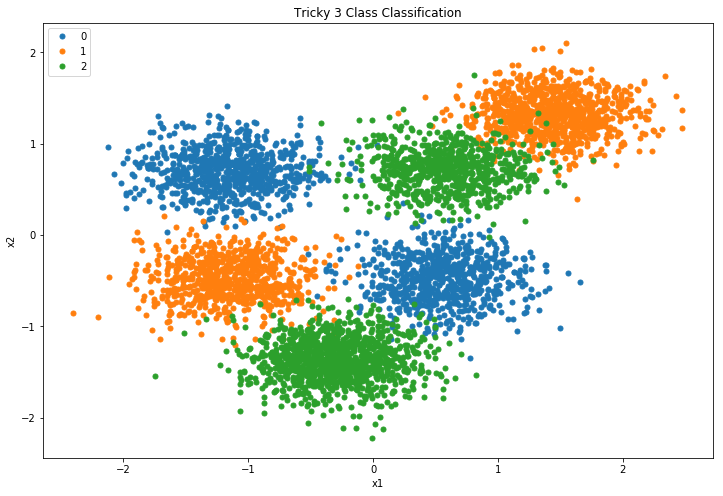

In [5]:
plot_data(X, y)

Now build your network. Good luck! 😉 

In [6]:
X = X.A
y = y.A

In [16]:
# my plot functions

def plot_loss(loss):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    
    ax.plot(loss)
    ax.set_xlabel('number of iterations')
    ax.set_ylabel('loss')
    ax.set_title('{} hidden layer ({} units per layer), learning rate: {}, batch size: {}, epoch: {}, accuracy: {}'\
                 .format(len(NN.hidden_layer_list), NN.hidden_layer_list[0].dim_out, NN.eta, NN.batch_size, NN.epoch, \
                        NN.get_accuracy(X, y)))
    plt.show()
    
def plot_decision_regions(NN):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    
    # draw boundaries 
    X_generated = np.random.uniform(-3, 3, (50000, 2))
    y_predicted = NN.predict(X_generated)
    indices_0 = [k for k in range(0, X_generated.shape[0]) if y_predicted[k] == 0]
    indices_1 = [k for k in range(0, X_generated.shape[0]) if y_predicted[k] == 1]
    indices_2 = [k for k in range(0, X_generated.shape[0]) if y_predicted[k] == 2]
    ax.plot(X_generated[indices_0, 0], X_generated[indices_0,1], marker='o', c='r', linestyle='', ms=5, label='0-region', zorder=1)
    ax.plot(X_generated[indices_1, 0], X_generated[indices_1,1], marker='o', c='m', linestyle='', ms=5, label='1-region', zorder=2)
    ax.plot(X_generated[indices_2, 0], X_generated[indices_2,1], marker='o', c='k', linestyle='', ms=5, label='2-region',zorder=3)

    # plot original data
    indices_0 = [k for k in range(0, X.shape[0]) if y[k] == 0]
    indices_1 = [k for k in range(0, X.shape[0]) if y[k] == 1]
    indices_2 = [k for k in range(0, X.shape[0]) if y[k] == 2]
    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', c='tab:blue', ms=5, label='0-sample', zorder=9)
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', c='tab:orange', ms=5, label='1-sample', zorder=10)
    ax.plot(X[indices_2, 0], X[indices_2,1], marker='o', linestyle='', c='tab:green', ms=5, label='2-sample',zorder=11)
        
    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('{} hidden layer ({} units per layer), learning rate: {}, batch size: {}, epoch: {}, accuracy: {}'\
                 .format(len(NN.hidden_layer_list), NN.hidden_layer_list[0].dim_out, NN.eta, NN.batch_size, NN.epoch, \
                        NN.get_accuracy(X, y)))
    plt.show()

In [8]:
class Hidden_layer:
    def __init__(self, dim_in, dim_out):
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.W = 0.01*np.random.randn(dim_in, dim_out)
        self.b = np.zeros((1, dim_out))
    
    def forward_propagation(self, X):
        r = X.dot(self.W) + self.b
        h = np.maximum(np.zeros(r.shape), r)
        return h
    
    def back_propagation(self, dLdh, h, X, eta):
        dhdr = np.zeros(h.shape)
        dhdr[np.nonzero(h)] = 1
        dLdr = np.multiply(dhdr, dLdh)
        dLdW = X.T.dot(dLdr)
        dLdb = np.mean(dLdr, axis=0).reshape(1, self.dim_out)
        dLdX = dLdr.dot(self.W.T)
        self.W = self.W - eta * dLdW
        self.b = self.b - eta * dLdb
        return dLdX
    
    def __repr__(self):
        return "dim_in: {}    dim_out: {} \nW:\n {} \n b:\n {}".format(self.dim_in, self.dim_out, self.W, self.b)
    
    def __str__(self):
        return "dim_in: {}    dim_out: {} \nW:\n {} \n b:\n {}".format(self.dim_in, self.dim_out, self.W, self.b)
    
    
class Output_layer:
    def __init__(self, dim_in, dim_out):
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.W = 0.01*np.random.randn(dim_in, dim_out)
        self.b = np.zeros((1, dim_out))
        
    def forward_propagation(self, h):
        z = h.dot(self.W) + self.b
        z = z - np.max(z, axis=1).reshape(z.shape[0], 1)
        return z
    
    def back_propagation(self, dLdz, h, eta):
        dLdh = dLdz.dot(self.W.T)
        dLdW = h.T.dot(dLdz)
        dLdb = np.mean(dLdz, axis=0).reshape(1, self.dim_out)
        self.W = self.W - eta * dLdW
        self.b = self.b - eta * dLdb
        return dLdh
    
    def __repr__(self):
        return "dim_in: {}    dim_out: {} \nW:\n {} \n b:\n {}".format(self.dim_in, self.dim_out, self.W, self.b)
    
    def __str__(self):
        return "dim_in: {}    dim_out: {} \nW:\n {} \n b:\n {}".format(self.dim_in, self.dim_out, self.W, self.b)
    
class Loss_layer:
    def __init__(self, dim_in, dim_out):
        self.dim_in = dim_in
        self.dim_out = dim_out
        
    def forward_propagation(self, z, y):
        temp = -z + np.log(np.sum(np.exp(z), axis=1)).reshape(z.shape[0], 1)
        L = temp[np.arange(z.shape[0]), y.flatten().astype(int)]
        return np.mean(L)
    
    def back_propagation(self, z, y):
        temp1 = np.exp(z) / np.sum(np.exp(z),axis=1).reshape(z.shape[0], 1)
        temp2 = np.zeros(z.shape)
        temp2[np.arange(z.shape[0]), y.flatten().astype(int)] = -1
        dLdz = temp1 + temp2
        return dLdz

In [9]:
class MLP:
    def __init__(self):
        self.hidden_layer_list = []
        self.output_layer = None
        self.loss_layer = None
        self.eta = None
        self.batch_size = None
        self.epoch = None
        
    def add_layer(self, type, dim_in, dim_out):
        if type=="Hidden":
            self.hidden_layer_list.append(Hidden_layer(dim_in, dim_out))
        elif type=="Output":
            self.output_layer = Output_layer(dim_in, dim_out)
        elif type=="Loss":
            self.loss_layer = Loss_layer(dim_in, dim_out)
        else:
            print("Error added layer!")
    
    def forward(self, X, y):
        h = self.hidden_layer_list[0].forward_propagation(X)
        z = self.output_layer.forward_propagation(h)
        L = self.loss_layer.forward_propagation(z, y)
        return h, z, L
    
    def backward(self, h, z, X, y, eta):
        dLdz = self.loss_layer.back_propagation(z, y)
        dLdh = self.output_layer.back_propagation(dLdz, h, eta)
        dLdX = self.hidden_layer_list[0].back_propagation(dLdh, h, X, eta)    
        
    def train(self, eta, batch_size, epoch, X, y):
        self.eta = eta
        self.batch_size = batch_size
        self.epoch = epoch
        
        All = np.concatenate((X, y), axis=1)
        loss = []
        for e in range(epoch):
            #print(e)
            All_permutated = np.random.permutation(All)
            for i in range(int(All.shape[0]/batch_size)):
                #print(i)
                X_batch = All_permutated[batch_size*i:batch_size*(i+1), 0:2]
                y_batch = All_permutated[batch_size*i:batch_size*(i+1), [2]]
                h, z, L = self.forward(X, y)
                loss.append(L)
                #print(z)
                self.backward(h, z, X, y, eta)
        return loss
    
    def predict(self, X):
        h = self.hidden_layer_list[0].forward_propagation(X)
        z = self.output_layer.forward_propagation(h)
        y = np.argmax(z, axis=1).reshape(z.shape[0], 1)
        return y
    
    def get_accuracy(self, X, y):
        y_predicted = self.predict(X)
        return np.count_nonzero(y_predicted==y)/X.shape[0]

# Now start the 24 plots (parameter values are in the title of each graph)

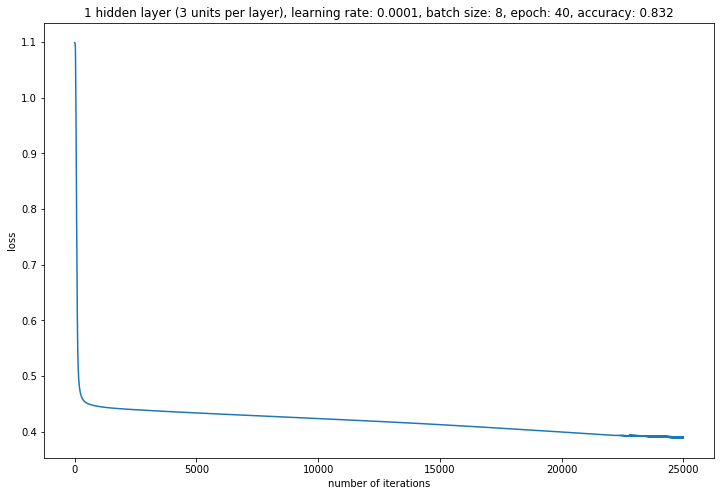

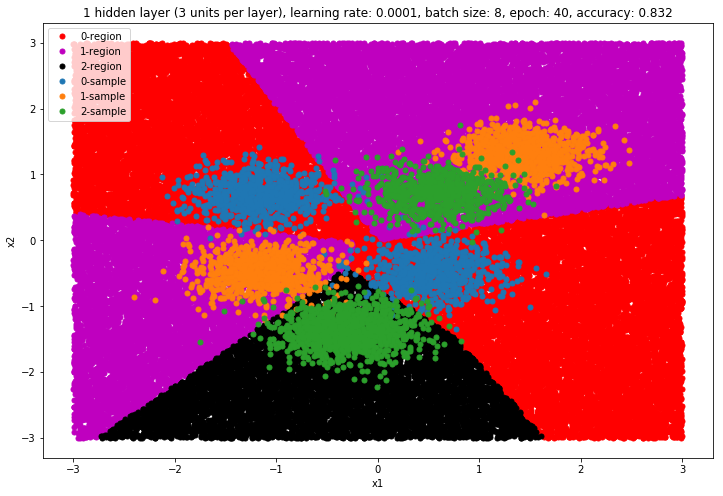

In [14]:
NN = MLP()
NN.add_layer("Hidden", dim_in=2, dim_out=3)
NN.add_layer("Output", dim_in=3, dim_out=3)
NN.add_layer("Loss", dim_in=3, dim_out=3)

loss = NN.train(eta=0.0001, batch_size=8, epoch=40, X=X, y=y)

plot_loss(loss)
plot_decision_regions(NN)

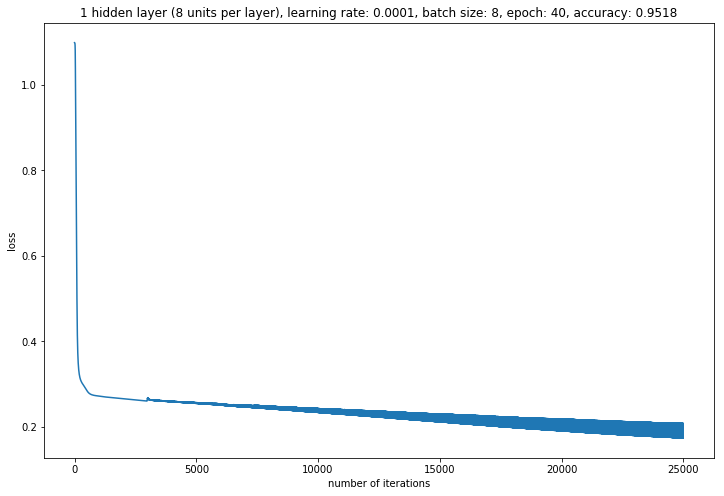

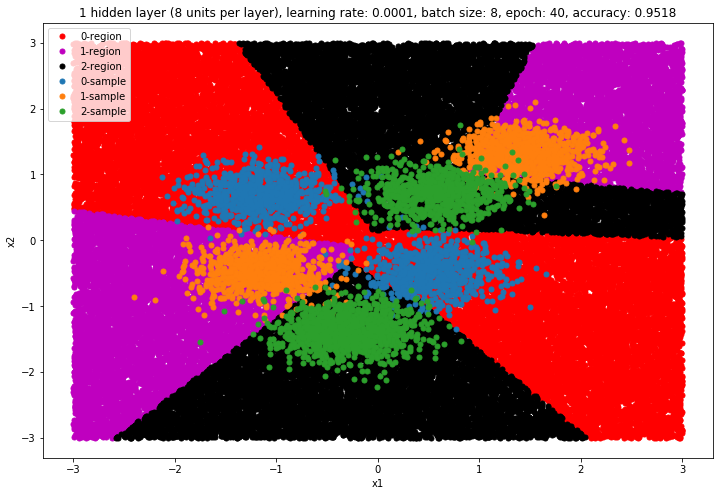

In [15]:
NN = MLP()
NN.add_layer("Hidden", dim_in=2, dim_out=8)
NN.add_layer("Output", dim_in=8, dim_out=3)
NN.add_layer("Loss", dim_in=3, dim_out=3)

loss = NN.train(eta=0.0001, batch_size=8, epoch=40, X=X, y=y)

plot_loss(loss)
plot_decision_regions(NN)

In [10]:
NN = MLP()
NN.add_layer("Hidden", dim_in=2, dim_out=16)
NN.add_layer("Output", dim_in=16, dim_out=3)
NN.add_layer("Loss", dim_in=3, dim_out=3)

loss = NN.train(eta=0.0001, batch_size=8, epoch=40, X=X, y=y)

plot_loss(loss)
plot_decision_regions(NN)

In [ ]:
h, z, L = NN.forward(X, y)
NN.backward(h, z, X, y, eta)
NN.hidden_layer_list[0]

In [246]:
eta = 0.005
# forward
hidden_layer = Hidden_layer(2, 16)
output_layer = Output_layer(16, 3)
loss_layer = Loss_layer(3, 3)
h = hidden_layer.forward_propagation(X)
z = output_layer.forward_propagation(h)
L = loss_layer.forward_propagation(z, y)

# backward
dLdz = loss_layer.back_propagation(z, y)
dLdh = output_layer.back_propagation(dLdz, h, eta)
dLdX = hidden_layer.back_propagation(dLdh, h, X, eta)